<div align="center">

# Обучение дерева решения 

</div>

---

**Цель** обучения дерева решений состоит в том, чтобы на каждом шаге выбирать признак, дающий максимальный прирост информации. Прирост информации (Information Gain, IG) при разбиении множества по признаку  вычисляется как разница между энтропией исходного множества и взвешенной суммой энтропий получившихся подмножеств:

$$
\mathrm{IG}(D_p, f)
= I(D_p)
- \sum_{j=1}^{m} \frac{\lvert N_j\rvert}{\lvert N_p\rvert}\;I(D_j),
$$

Где $f$ - функция для выполнения разделения, $D_p$ и $D_j$ - наборы данных родительского и дочерних узлов, $I$ - мера примеси (impurity), $N_p$ - обшее кол-во обучающих примеров на родительском узле, а $N_j$ на дочернем узле. Прирост информации - это разница между примесью родительского узла и суммой примесей дочерних узлов, то есть чем ниже примеси дочерних узлов, тем больше прирост информации. 

Для сокращения пространства комбинаторного поиска в `scikit-learn` - реализуются бинарные деревья решений. Это означает, что каждый родительский узел разделяется строго на два дочерних узла $D_left$ и $D_right$:

$$
\mathrm{IG}(D_p, f)
= I(D_p)
- \frac{\lvert N_{\mathrm{left}}\rvert}{\lvert N_p\rvert}\;I(D_{\mathrm{left}})
- \frac{\lvert N_{\mathrm{right}}\rvert}{\lvert N_p\rvert}\;I(D_{\mathrm{right}}).
$$

Три меры примеси, или критерия разделения, которые обычно используются в бинарных деревьях решений, это примесь **Джини (Gini Impurity, $I$)**, **энтропия (Entropy, $I_H$)** и **ошибка классификации (Classification Error, IE)**

1. **Примесь Джини (Gini Impurity, $(I_G)$)**  
   Формула:

   $$
     I_G(t) = 1 - \sum_{i=1}^{c} p(i \mid t)^2,
   $$

   
   *Суть:* критерий Джини можно рассматривать как критерий минимизации вероятности ошибочной классификации. $(I_G)$ достигает максимума, когда классы полностью перемешаны, и стремится к нулю, когда узел «чист» (все объекты одного класса).



2. **Энтропия (Entropy, $(I_H$))**
   Формула:

   
   $$
     I_H(t) = -\sum_{i=1}^{c} p(i|t) \,\log_2 p(i|t).
   $$

   *Суть:*  $p(i|t)$ - доля экземпляров принадлежащих классу $i$ для конкретного узла $t$. Энтропия равна 0, если все объекты в узле принадлежат одному классу, и достигает максимума при равномерном распределении классов. Критерий энтропии направлен на максимизацию прироста информации (information gain) при разбиении.

3. **Ошибка классификации (Classification Error, $(I_E$))**  
   Формула:

   
   $$
     I_E(t) = 1 - \max{p(i|t)}.
   $$

   *Суть:* отражает долю «неправильно» классифицированных объектов при выборе наиболее частого класса. Эта мера менее чувствительна к изменениям в распределении классов по сравнению с Gini и энтропией, поэтому используется реже. Ошибка классификации полезный критерий для обрезки дерева, но его не рекомендуется применять при построении дерева решений, посколько он менее чувствителен к изменениям вероятностей классов узлов.
   



На практике примесь Джини и Энтропии, часто дают похожие результаты.


Используя алгоритм принятия решения, мы начинаем с корня дерева и разделяем данные по признаку, который приводит к наибольшему приросту информации (Information Gain, IG).
После чего мы итеративно повторяем эту процедуру разделения на каждом узле, пока листья дерева не станут чистыми (pure). Это означает, что все обучающие экземпляры в каждом узле принадлежат одному и тому же классу. 
Может получится очень глубокое дерево с множеством узлов, что легко приводит к переобучению, но можно обрезать дерево, установив ограничения на максимальную глубину дерева.

---

Для наглядного сравнения трёх критериев примеси, построим график значений каждого из них в зависимости от вероятности принадлежности объекта к классу 1 (в диапазоне от 0 до 1).

На графике также будет показана масштабированная энтропия (энтропия, делённая на 2), чтобы лучше продемонстрировать взаимосвязь между мерами:
примесь Джинни оказывается промежуточной между энтропией и ошибкой классификации при любых значениях вероятности.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

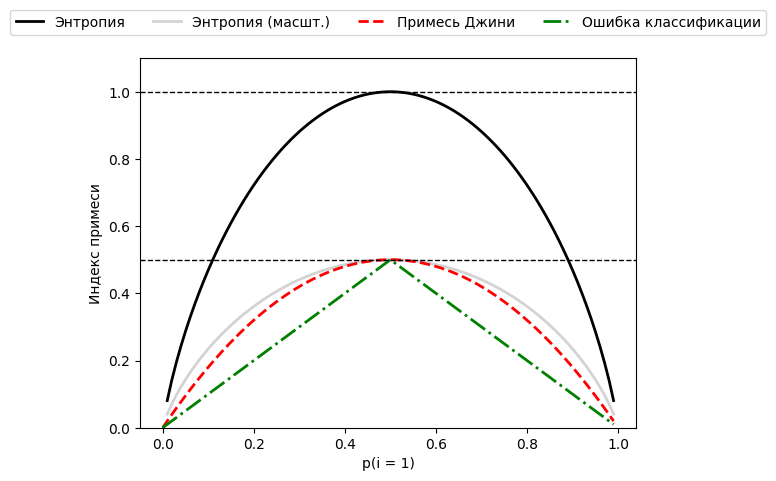

In [2]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))
def entropy(p):
    return -p * np.log2(p) - (1 - p)*np.log2((1 - p))
def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                         ['Энтропия', 'Энтропия (масшт.)',
                           'Примесь Джини', 
                           'Ошибка классификации'],
                           ['-', '-', '--', '-.'],
                            ['black', 'lightgray',
                            'red', 'green', 'cyan']):
             line = ax.plot(x, i, label = lab, linestyle = ls, lw = 2, color = c)
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, 1.15),
         ncol = 5, fancybox = True, shadow = False)
ax.axhline(y = 0.5, linewidth = 1, color = 'k', linestyle = '--')
ax.axhline(y = 1.0, linewidth = 1, color = 'k', linestyle = '--')
plt.ylim([0, 1.1])
plt.xlabel('p(i = 1)')
plt.ylabel('Индекс примеси')
plt.show()

Представьте, что вы смотрите на дерево решений и хотите понять, насколько «грязным» может быть любой его узел в зависимости от того, насколько в нём смешаны классы. Для этого мы рисуем график:

- **Ось X** — вероятность \(p\), что случайно выбранный объект в узле принадлежит классу 1.  
- **Ось Y** — значение меры примеси (чем выше, тем «грязнее» узел).

Когда \(p=0\) или \(p=1\), все объекты одного класса, и все кривые сходятся к нулю — узел чист. По мере удаления \(p\) от границ 0 и 1, узел становится менее однородным, и меры примеси растут. При \(p=0.5\) (равное смешение классов) каждая кривая достигает своего максимума:  
- **Энтропия** (чёрная сплошная) — до 1.  
- **Примесь Джинни** (красная пунктирная) — до 0.5.  
- **Ошибка классификации** (зелёная штрих‑пунктирная) — до 0.5.

**Что видно на графике?**

1. **Энтропия** взмывает вверх даже при малом «шуме» (например, при \(p=0.01\) или \(p=0.99\) она уже заметно выше нуля). Это показывает её высокую чувствительность к неопределённости.
2. **Примесь Джинни** растёт чуть медленнее — она более «гладкая», но всё равно эффективно отражает степень перемешанности классов.
3. **Ошибка классификации** почти не меняется, пока \(p\) не приблизится к 0.5, а затем быстро растёт — это самая грубая мера, наименее чувствительная к небольшим отклонениям.

**Выводы для практики**:

- Если нужна очень тонкая грануляция узлов с минимальным смешением классов, можно воспользоваться **энтропией**.  
- Если хочется компромисса между чувствительностью и стабильностью, тогда выбор в пользу **примесь Джинни** (именно её по умолчанию берёт `scikit-learn`).  
- Если важна простота и «быстрая» оценка однородности, подходит **ошибка классификации** — чаще всего для обрезки (pruning) готового дерева.

Таким образом, график наглядно демонстрирует, как каждая мера реагирует на степень смешения классов и почему на практике выбирают именно примесь Джинни: она оптимально балансирует между чувствительностью и устойчивостью.

---

## Построение дерева решений с помощью scikit-learn

Деревья решений - могут создавать сложные решающие границы, разделяя пространство признаков на прямоугольники. 
Главное помнить, чем глубже дерево, тем сложнее становится решающая граница, что может приводить к переобучению.

Мы обучим дерево с максимальной глубиной 4, используя в качестве критерия примесь Джини.

### Почему при препроцессинге, масштабирование признаков не обязательно для деревьев решений:

Деревья решений (например, `DecisionTreeClassifier` из `scikit-learn`) **не зависят от абсолютного масштаба признаков**, поскольку:

- **Нет операций над расстояниями или градиентами**  
  В отличие от k‑NN или алгоритмов, основанных на градиентном спуске, дерево решений не вычисляет расстояния между точками и не оптимизирует непрерывную функцию потерь.

- **Разбиения по пороговым значениям**  
  На каждом узле дерево просто проверяет условие вида  
  ```text
  если признак X > θ — перейти в правое поддерево, иначе — в левое



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
# 1) Загрузка всех образцов Iris
iris   = datasets.load_iris()
X_all  = iris.data        # shape (150, 4)
y_all  = iris.target      # shape (150,)

# 2) Выбор двух признаков: petal length (индекс 2) и petal width (индекс 3)
X_23   = X_all[:, [2, 3]]

# Делим X_23 и y_all на train и test
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_23, y_all, np.arange(len(y_all)),
    test_size=0.3,          # 30% тест
    random_state=1,
    stratify=y_all          # сохраняем пропорции классов
)


In [5]:
# Обучени модели Decision Tree
tree_model = DecisionTreeClassifier(criterion = 'gini',
                                    max_depth = 4,
                                    random_state = 1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))


In [6]:
# График визуализации областей принятия решений SVM
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap    = ListedColormap(colors[:len(np.unique(y))])

    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Отрисовка всех образцов
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f'Класс {cl}',
            edgecolor='black'
        )

    # Подсветка тестовых образцов, если переданы индексы
    if test_idx is not None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            X_test[:, 0], X_test[:, 1],
            facecolors='none',
            edgecolors='black',
            alpha=1.0,
            linewidth=1,
            marker='o',
            s=100,
            label='Тестовый набор'
        )

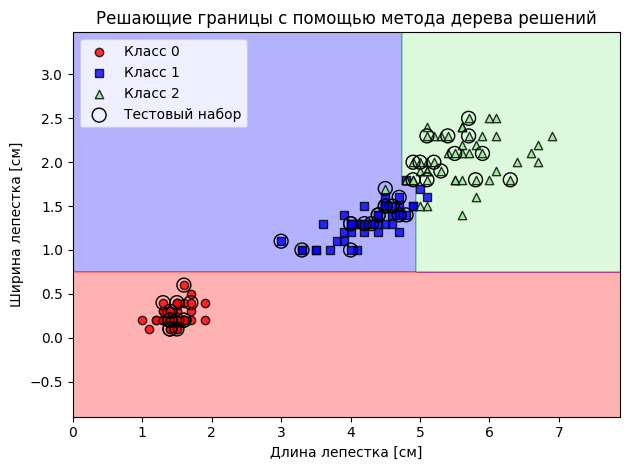

In [7]:
plot_decision_regions(X_combined,
                      y_combined,
                      classifier = tree_model,
                      test_idx = range(105, 150))
plt.xlabel('Длина лепестка [см]')
plt.ylabel('Ширина лепестка [см]')
plt.title('Решающие границы с помощью метода дерева решений')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

Можно с помощью библиотеки scikit-learn визуализировать модель дерева решения. Установив параметр `filled = True`, мы вызовем цвета узлов по метке большинства классов в этом узле. 

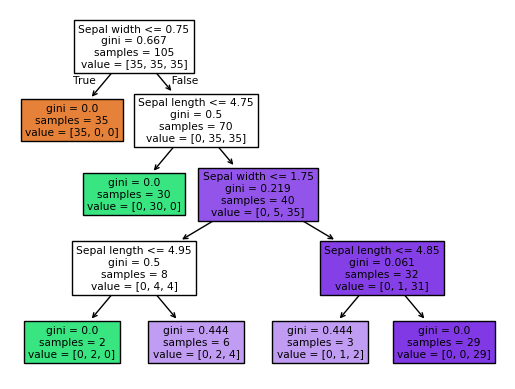

In [8]:
feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model,
               feature_names = feature_names,
               filled = True)
plt.show()

Глядя на эту схему, можно хорошо проследить разбиение, которое дерево решений опредилило из обучающего набора данных Iris. Ветви слева соответсвуют исходу `True` (истина), а ветви справа - `False` (ложь).
Расположенный вверху корневой узел начинается со 105 экземпляров. В первом ветвлении используется пороговый критерий `«sepal width (ширина чашелистика)` $\leq$ `0.75 см»`, который делит данные корневого узла на два дочерних узла с 35 экземплярами (слева) и 70 экземплярами (справа). Уже после первого ветвления мы видим, что левый дочерний узел чист от примесей и содержит только экземпляры класса Iris-setosa (примесь джини = 0). Дальнейшие ветвления в правой части используются для разделения
экземпляров классов Iris-versicolor и Iris-virginica.

Рассматривая схему дерева решений и диаграмму решающих областей, можно сделать
вьвод, что дерево решений очень хорошо разделяет классы цветков.

---

## Случайный лес (Random Forest)

Случайный лес — это ансамблевый метод, объединяющий множество деревьев решений для повышения стабильности и обобщающей способности модели.

---

### Зачем нужен случайный лес?

- **Уменьшает переобучение**  
  Глубокие деревья часто страдают от высокой дисперсии. Усреднение их прогнозов даёт более устойчивую модель.  
- **Хорошо масштабируется**  
  Обучение деревьев можно легко распараллелить по разным CPU‑ядрам или узлам кластера.

---

### Идея

1. **Несколько “несовершенных” экспертов**  
   Каждое отдельное дерево обучается на случайной части данных — оно может переобучаться, но при усреднении ошибок компенсирует друг друга.  
2. **Случайность для разнообразия**  
   - Бутстрэп‑выборка (с возвращением) создаёт разные обучающие подмножества.  
   - В каждом узле дерева рассматривается лишь случайный поднабор признаков.

---

### Алгоритм

1. **Бутстрэп‑выборка**  
   Случайным образом выбираем \(n\) образцов с возвращением из обучающего набора (размер обычно равен исходному объёму данных).
2. **Обучение одного дерева**  
   - На каждом узле случайно отбираем \(d\) признаков (без возвращения).  
   - Выбираем лучший признак по критерию (например, Gini или энтропия) и разбиваем узел.  
3. **Повторение**  
   Шаги 1–2 выполняем \(k\) раз, получая \(k\) деревьев.
4. **Агрегация**  
   Для классификации применяем правило большинства (majority vote); для регрессии — усреднение.

---

### Основные гиперпараметры

- **\(k\) — число деревьев**  
  Больше деревьев → ниже дисперсия, но выше затраты времени и памяти.  
- **\(n\) — размер бутстрэп‑выборки**  
  Стандартно $(n = N$) (полный объём данных). Уменьшение $(n$) повышает разнообразие деревьев, но может ухудшить обобщение.  
- **\(d\) — число признаков в каждом узле**  
  Рекомендуемое значение: $(\sqrt{m}$) для классификации (где $(m$) — общее число признаков).

---

### Практические советы

- **По умолчанию** `scikit‑learn` использует:  
  - `n_estimators=100` (число деревьев)  
  - `max_features="sqrt"` (для классификации)  
  - `bootstrap=True` (бутстрэп‑выборка)  
- **Валидация**  
  Подбирайте `n_estimators` и `max_depth` через кросс‑валидацию, чтобы найти баланс между скоростью и качеством.
- **Интерпретация**  
  Оценивайте важность признаков (`feature_importances_`), чтобы понять, какие переменные вносят наибольший вклад.

---

Случайный лес — надёжный «рабочий конь» в задачах классификации и регрессии: прост в настройке, устойчив к шуму и часто даёт близкие к оптимальным результаты без сильного переобучения.  


In [9]:
# Обучаем модель Случайный лес
forest = RandomForestClassifier(n_estimators = 25,
                                random_state = 1,
                                n_jobs = 2)
forest.fit(X_train, y_train)

,n_estimators,25
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


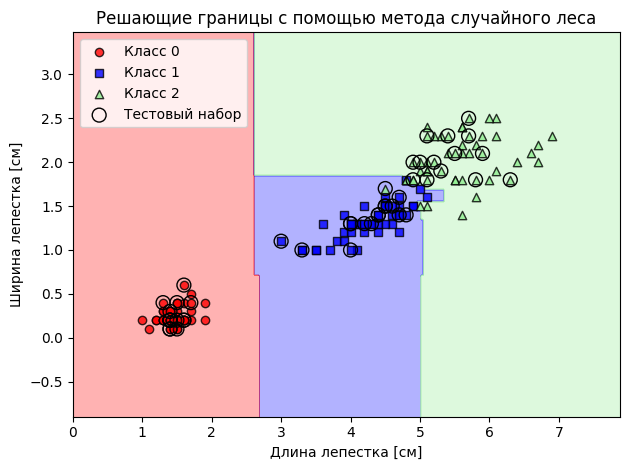

In [10]:
# Строим график области принятия решения Random Forest
plot_decision_regions(X_combined, y_combined,
                      classifier = forest,
                      test_idx = range(105, 150))
plt.xlabel('Длина лепестка [см]')
plt.ylabel('Ширина лепестка [см]')
plt.title('Решающие границы с помощью метода случайного леса')
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

После обучения модели случайный лес из 25 деревьев, можно сделать вывод, что алгоритм хорошо обобщается. По умолчанию этот метод использует меру примеси Джини в качестве критерия для ветвления в узлах.
Хотя мы выращиваем очень маленький случайный лес из небольшого набора обучающих данных, мы применили в демонстрационных целях параметр `n_jobs`, который позволяет распараллелить обучение модели с использованием нескольких ядер нашего компьютера (здесь - двух ядер).